In [10]:
# made by Gibeom LEE, HI LAB
# Vpp finder와 기능은 같음. 다만, 일부분 피크를 발췌해서 정리해줌!

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [12]:
# 사용자 선택: 피크 탐지 모드
# "neg"  → 음의 피크만 (Abs. Peak Mag. 분석)
# "pos"  → 양의 피크만 (Abs. Peak Mag. 분석)
# "both" → 양/음 피크 모두 (Vpp 분석)
peak_mode = "neg"

# -------------------------------
# 폴더 경로
folder_path = r"C:\Users\user\Desktop\Drive파일\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\1. 실험자료\최최종피규어들\csv파일\Current & Charge\Aloe_2cm"


# 사용자 설정값
prominence_ratio = 0.3   # 표준편차(std) * 비율로 prominence 기준 설정
min_prominence   = 0.05   # prominence 하한 
min_distance_sec = 0.1 # 인접 피크 최소 간격(초)
snr_threshold    = 1     # SNR 기준
min_relative_height = 0.1  # 전체 최대 진폭 대비 최소 비율
abs_min_height = 1       # 최소 피크 height

window_peaks = 10       # <<<< 연속 피크 개수

# 그래프 Y축ws
y_range = (None, None)
#y_range = (-10, 5)

current_scale = 1 #only with currnet raw data | ex) 10 = 10 μA/V

# csv파일 저장
save_summary_csv = False  # False 로 하면 CSV 저장 안 함
#save_summary_csv = True

tek0020ALL_Peak value: -1.68 V
tek0020ALL_Peak number: 1개
tek0020ALL_표준편차: 0.00
tek0020ALL_주파수: 0.00 Hz


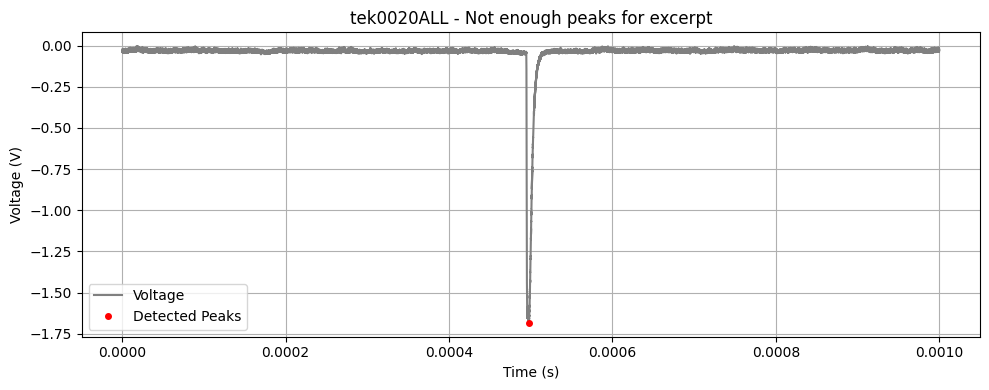

tek0021ALL_Peak value: -1.42 V
tek0021ALL_Peak number: 1개
tek0021ALL_표준편차: 0.00
tek0021ALL_주파수: 0.00 Hz


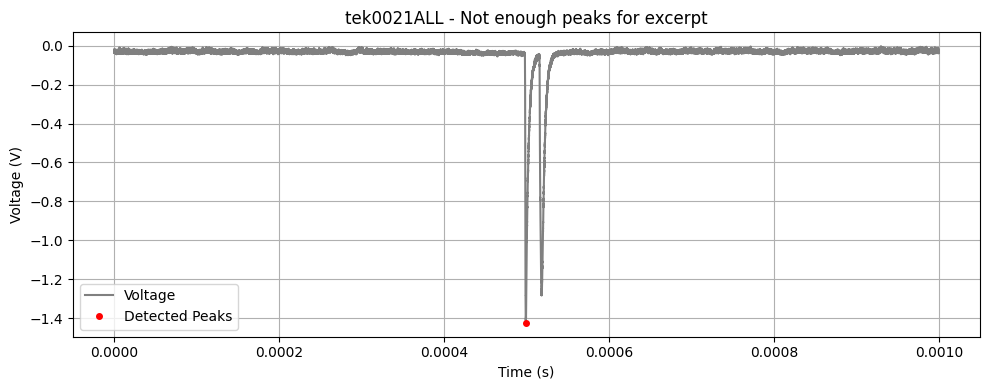

tek0022ALL_Peak value: -1.94 V
tek0022ALL_Peak number: 1개
tek0022ALL_표준편차: 0.00
tek0022ALL_주파수: 0.00 Hz


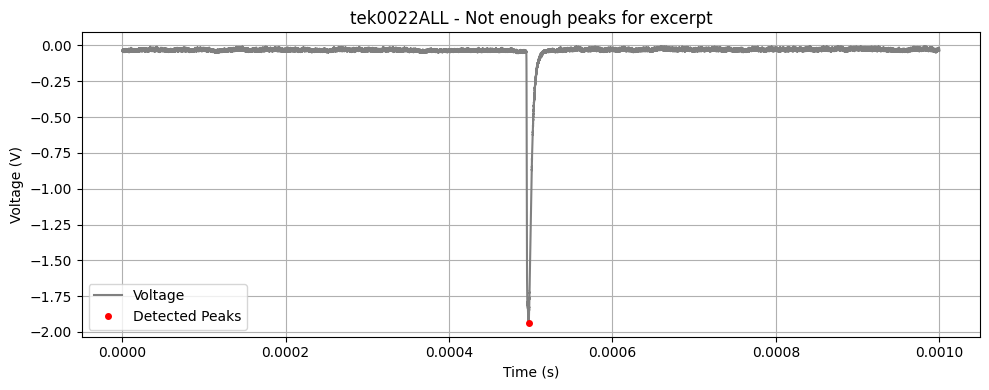

tek0023ALL_Peak value: -2.30 V
tek0023ALL_Peak number: 1개
tek0023ALL_표준편차: 0.00
tek0023ALL_주파수: 0.00 Hz


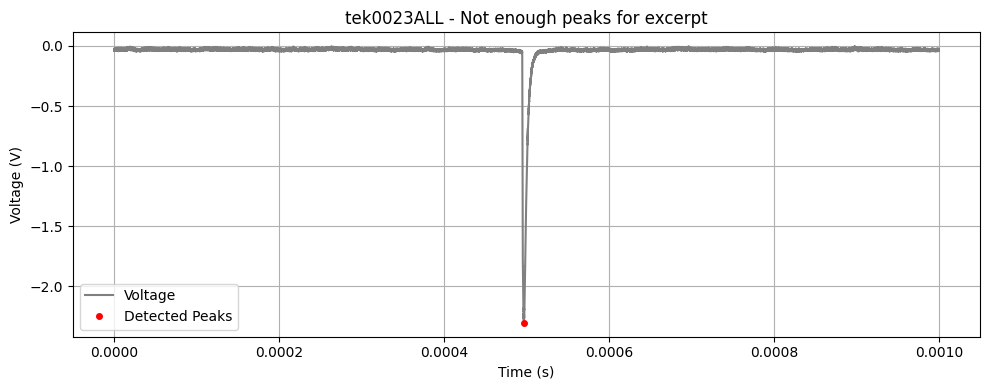

tek0024ALL_Peak value: -1.43 V
tek0024ALL_Peak number: 1개
tek0024ALL_표준편차: 0.00
tek0024ALL_주파수: 0.00 Hz


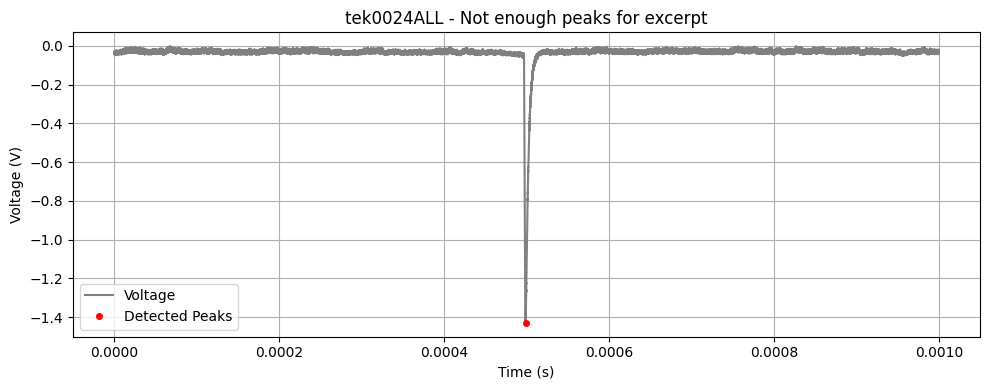


🎯 모든 파일 발췌 결과 요약 (연속 10개 피크 기준)
📭 데이터가 없습니다.


In [13]:
# ============================================================
# 파일 로드 및 초기 설정
# ============================================================

try:
    csv_files = sorted([
        f for f in os.listdir(folder_path)
        if f.endswith('.csv') and f != "00summary.csv"
    ])
except FileNotFoundError:
    print(f"❌ Error: Folder not found at {folder_path}")
    csv_files = []

all_analysis_values = []
file_std_values = []
all_freq_values = []

excerpt_mean_analysis_list = []
excerpt_std_analysis_list = []
excerpt_mean_freq_list = []

analysis_unit = "Vpp" if peak_mode == "both" else "Peak value"

# ============================================================
# 파일 반복 루프
# ============================================================

for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)

    try:
        # 데이터 로드
        df = pd.read_csv(file_path, skiprows=30)
        time = df.iloc[:, 0].values
        voltage = df.iloc[:, 1].values * current_scale

        # 샘플링 속도 계산
        total_time = time[-1] - time[0]
        sampling_rate = len(time) / total_time
        distance = int(sampling_rate * min_distance_sec)

        # 피크 탐지 prominence 기준
        prom = max(np.std(voltage) * prominence_ratio, min_prominence)

        # ------------------------------------------------------------
        # 피크 탐지
        # ------------------------------------------------------------
        if peak_mode == "neg":
            raw_peaks, _ = find_peaks(-voltage, prominence=prom, distance=distance)
        elif peak_mode == "pos":
            raw_peaks, _ = find_peaks(voltage, prominence=prom, distance=distance)
        elif peak_mode == "both":
            raw_peaks_pos, _ = find_peaks(voltage, prominence=prom, distance=distance)
            raw_peaks_neg, _ = find_peaks(-voltage, prominence=prom, distance=distance)
            raw_peaks = np.sort(np.concatenate([raw_peaks_pos, raw_peaks_neg]))
        else:
            raise ValueError("peak_mode는 'neg', 'pos', 'both' 중 하나여야 합니다.")

        # ------------------------------------------------------------
        # 피크 필터링
        # ------------------------------------------------------------
        max_amplitude = np.max(np.abs(voltage)) if len(voltage) > 0 else 0.0
        final_peaks = []

        for i in raw_peaks:
            left = max(0, i - int(0.05 * sampling_rate))
            right = min(len(voltage), i + int(0.05 * sampling_rate))
            local_noise = max(np.std(voltage[left:right]), 1e-6)
            signal = abs(voltage[i])

            if (
                signal > max_amplitude * min_relative_height and
                (signal / local_noise) > snr_threshold and
                signal > abs_min_height
            ):
                final_peaks.append(i)

        final_peaks = np.array(final_peaks, dtype=int)
        peak_times = time[final_peaks]

        # ------------------------------------------------------------
        # 분석 값 계산
        # ------------------------------------------------------------
        analysis_list = []
        for i in range(len(final_peaks) - 1):
            s, e = final_peaks[i], final_peaks[i + 1]
            if peak_mode == "both":
                analysis_val = np.max(voltage[s:e + 1]) - np.min(voltage[s:e + 1])
            else:
                val_i = voltage[final_peaks[i]]
                val_j = voltage[final_peaks[i + 1]]
                analysis_val = (val_i + val_j) / 2
            analysis_list.append(analysis_val)

        if len(final_peaks) >= 2:
            mean_analysis = float(np.mean(analysis_list)) if analysis_list else 0.0
            std_analysis = float(np.std(analysis_list, ddof=1)) if len(analysis_list) > 1 else 0.0
        elif len(final_peaks) == 1:
            mean_analysis = voltage[final_peaks[0]]
            std_analysis = 0.0
        else:
            mean_analysis = 0.0
            std_analysis = 0.0

        # 주파수 계산
        if len(peak_times) >= 2:
            periods = np.diff(peak_times)
            mean_freq = float(np.mean(1.0 / periods))
        else:
            mean_freq = 0.0

        base_name = os.path.splitext(file_name)[0]
        print(f"{base_name}_{analysis_unit}: {mean_analysis:.2f} V")
        print(f"{base_name}_Peak number: {len(final_peaks)}개")
        print(f"{base_name}_표준편차: {std_analysis:.2f}")
        print(f"{base_name}_주파수: {mean_freq:.2f} Hz")

        all_analysis_values.append(mean_analysis)
        file_std_values.append(std_analysis)
        all_freq_values.append(mean_freq)

        # ------------------------------------------------------------
        # 발췌 윈도우 분석
        # ------------------------------------------------------------
        if len(final_peaks) >= window_peaks:
            peak_values = voltage[final_peaks].astype(float)
            peak_mags = np.abs(peak_values)

            csum = np.cumsum(peak_mags)
            sums = csum[window_peaks - 1:] - np.concatenate(([0.0], csum[:-window_peaks]))
            best_start = int(np.argmax(sums))
            best_end = best_start + window_peaks

            excerpt_idx = final_peaks[best_start:best_end]
            excerpt_times = time[excerpt_idx]
            excerpt_analysis_values = peak_values[best_start:best_end]
            excerpt_mags = peak_mags[best_start:best_end]

            if window_peaks == 1:
                excerpt_mean_analysis = float(np.mean(excerpt_analysis_values)) if len(excerpt_analysis_values) > 0 else 0.0
                excerpt_std_analysis = float(np.std(excerpt_analysis_values, ddof=1)) if len(excerpt_analysis_values) > 1 else 0.0
            else:
                excerpt_analysis = []
                for j in range(window_peaks - 1):
                    s = excerpt_idx[j]
                    e = excerpt_idx[j + 1]
                    if peak_mode == "both":
                        analysis_seg = np.max(voltage[s:e + 1]) - np.min(voltage[s:e + 1])
                    else:
                        val_i = voltage[excerpt_idx[j]]
                        val_j = voltage[excerpt_idx[j + 1]]
                        analysis_seg = (val_i + val_j) / 2
                    excerpt_analysis.append(analysis_seg)

                excerpt_mean_analysis = np.mean(excerpt_analysis) if excerpt_analysis else 0.0
                if analysis_unit == "Vpp":
                    excerpt_std_analysis = np.std(excerpt_analysis, ddof=1) if len(excerpt_analysis) > 1 else 0.0
                else:
                    excerpt_std_analysis = np.std(excerpt_analysis_values, ddof=1) if len(excerpt_analysis_values) > 1 else 0.0

            if len(excerpt_times) >= 2:
                excerpt_periods = np.diff(excerpt_times)
                excerpt_mean_freq = float(np.mean(1.0 / excerpt_periods))
            else:
                excerpt_mean_freq = 0.0

            print(f"👉 {base_name} 발췌(연속 {window_peaks}개) 정보")
            print(f"   - 합계(피크 크기 합): {np.sum(excerpt_mags):.2f}")
            print(f"   - 발췌 평균 {analysis_unit}: {excerpt_mean_analysis:.2f} V (표준편차: {excerpt_std_analysis:.2f} V)")
            print(f"   - 발췌 평균 주파수: {excerpt_mean_freq:.2f} Hz")

            excerpt_mean_analysis_list.append(excerpt_mean_analysis)
            excerpt_std_analysis_list.append(excerpt_std_analysis)
            excerpt_mean_freq_list.append(excerpt_mean_freq)

            # 그래프 표시
            plt.figure(figsize=(10, 4))
            plt.plot(time, voltage, label='Voltage')
            plt.plot(time[final_peaks], voltage[final_peaks], 'o', ms=4, label='Detected Peaks')
            plt.plot(time[excerpt_idx], voltage[excerpt_idx], 'ro', ms=6, label=f'Excerpt {window_peaks} Peaks')
            plt.axvspan(time[excerpt_idx[0]], time[excerpt_idx[-1]], alpha=0.15, label='Excerpt window')
            plt.title(f"{base_name} - Peak Detection + Excerpt {window_peaks}")
            plt.xlabel("Time (s)")
            plt.ylabel("Voltage (V)")
            plt.ylim(y_range)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

        else:
            plt.figure(figsize=(10, 4))
            plt.plot(time, voltage, label='Voltage', color='gray')
            plt.plot(time[final_peaks], voltage[final_peaks], 'ro', ms=4, label='Detected Peaks')
            plt.title(f"{base_name} - Not enough peaks for excerpt")
            plt.xlabel("Time (s)")
            plt.ylabel("Voltage (V)")
            plt.ylim(y_range)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"⚠️ {file_name} 처리 중 오류 발생: {e}")

# ============================================================
# 전체 요약 출력 및 CSV 저장
# ============================================================

print("\n==============================")
print(f"🎯 모든 파일 발췌 결과 요약 (연속 {window_peaks}개 피크 기준)")

for i in range(len(excerpt_mean_analysis_list)):
    if i < len(csv_files):
        print(
            f"{csv_files[i]} | {analysis_unit}: {excerpt_mean_analysis_list[i]:.2f} V | "
            f"표준편차: {excerpt_std_analysis_list[i]:.2f} V | "
            f"주파수: {excerpt_mean_freq_list[i]:.2f} Hz"
        )

if excerpt_mean_analysis_list:
    avg_analysis = float(np.mean(excerpt_mean_analysis_list))
    avg_std = float(np.std(excerpt_mean_analysis_list, ddof=1)) if len(excerpt_mean_analysis_list) > 1 else 0.0
    avg_freq = float(np.mean(excerpt_mean_freq_list))

    print("\n==============================")
    print(f"📊 전체 평균 {analysis_unit}: {avg_analysis:.2f} V")
    print(f"📉 평균 표준편차: {avg_std:.2f} V")
    print(f"🎵 평균 주파수: {avg_freq:.2f} Hz")

    if save_summary_csv:
        summary_df = pd.DataFrame({
            "File": csv_files[:len(excerpt_mean_analysis_list)],
            analysis_unit.replace(" ", "_"): excerpt_mean_analysis_list,
            "Std": excerpt_std_analysis_list,
            "Freq": excerpt_mean_freq_list
        })
        output_path = os.path.join(folder_path, "00summary.csv")
        summary_df.to_csv(output_path, index=False, encoding="utf-8-sig")
        print(f"✅ 요약 결과 CSV 저장 완료: {output_path}")
else:
    print("📭 데이터가 없습니다.")
